Loading final trained model...
Initializing SHAP explainer...
Generating SHAP explanations...
Displaying local SHAP explanations:

Sample 1: Your account has been suspended. Click here to verify your details.



Sample 2: We noticed unusual activity on your account. Please update your information immediately.



Sample 3: Meeting scheduled for tomorrow at 10 AM. Let me know if you can attend.



Sample 4: Happy birthday! Wishing you a fantastic year ahead.


Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


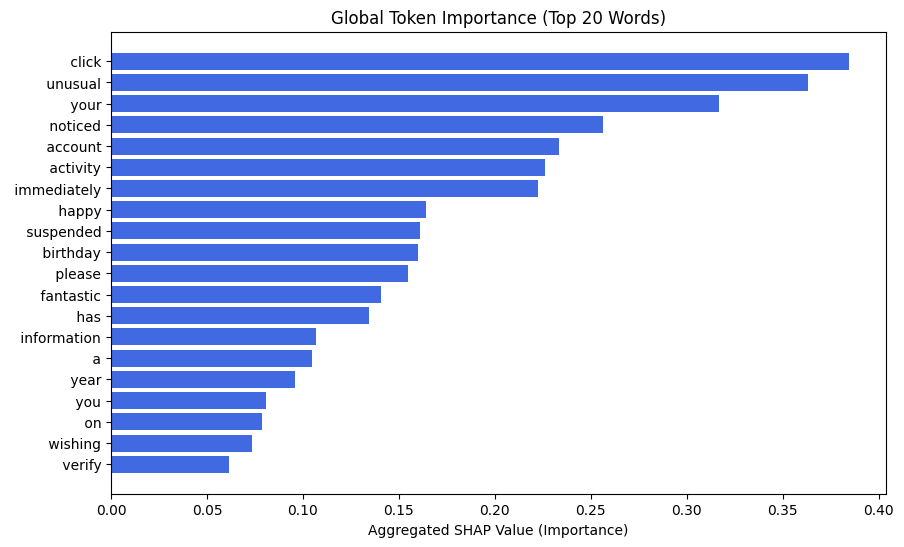

In [7]:
import torch
import shap
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from transformers import BertTokenizer, BertModel

from src.model.build_model import HybridModel
from src.utils.config import *

# ===== Step 1: Load Final Model =====
print("Loading final trained model...")
tokenizer = BertTokenizer.from_pretrained(TRANSFORMER_MODEL)
bert = BertModel.from_pretrained(TRANSFORMER_MODEL)
model = HybridModel(bert, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, mode=MODEL_MODE)
model.load_state_dict(torch.load(f"models/final_model_{MODEL_MODE}.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# ===== Step 2: Define Prediction Function for SHAP =====
def predict_proba(texts):
    # Handle SHAP masked inputs
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, list):
        texts = [str(t) for t in texts]
    elif isinstance(texts, str):
        texts = [texts]

    inputs = tokenizer(texts, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(inputs["input_ids"], inputs["attention_mask"])
    return outputs.cpu().numpy()

# ===== Step 3: Select Sample Texts =====
fraudulent_samples = [
    "Your account has been suspended. Click here to verify your details.",
    "We noticed unusual activity on your account. Please update your information immediately."
]

legitimate_samples = [
    "Meeting scheduled for tomorrow at 10 AM. Let me know if you can attend.",
    "Happy birthday! Wishing you a fantastic year ahead."
]

samples = fraudulent_samples + legitimate_samples

# ===== Step 4: Initialize SHAP Explainer with Text Masker =====
print("Initializing SHAP explainer...")
explainer = shap.Explainer(predict_proba, shap.maskers.Text(tokenizer))

# ===== Step 5: Generate SHAP Values =====
print("Generating SHAP explanations...")
shap_values = explainer(samples)

# ===== Step 6: Local Explanations (Interactive) =====
print("Displaying local SHAP explanations:")
for i, text in enumerate(samples):
    print(f"\nSample {i+1}: {text}")
    shap.plots.text(shap_values[i])  # Displays inline in Jupyter (perfect for screenshots)

# ===== Step 7: Global Token Importance =====
token_importance = defaultdict(float)

# Aggregate absolute SHAP values per token
for i in range(len(samples)):
    tokens_data = shap_values[i].data
    values = shap_values[i].values
    for token, val in zip(tokens_data, values):
        token_importance[token] += abs(val)

# Sort and select top 20 tokens
sorted_tokens = sorted(token_importance.items(), key=lambda x: x[1], reverse=True)[:20]

# Prepare tokens and scores
tokens, scores = zip(*sorted_tokens)
tokens = [str(t) for t in tokens]
scores = [float(s) for s in scores]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(tokens, scores, color='royalblue')
plt.xlabel("Aggregated SHAP Value (Importance)")
plt.title("Global Token Importance (Top 20 Words)")
plt.gca().invert_yaxis()
plt.show()

